<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/terminal_scripts/Final_Code_NEB_FOR_PAPER_nebstrat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [ ]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 4.7MB/s 
     |████████████████████████████████| 6.7MB 8.7MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 2.2MB 56.8MB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 110.5MB 29kB/s 
     |████████████████████████████████| 3.8MB 26.5MB/s 
     |████████████████████████████████| 512kB 53.1MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatib

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [ ]:
! nvidia-smi

Sun Oct 25 23:58:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty,neb_query
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 22.1 seconds


**Important Note**: The QE colab calculator only works with some GPUs provided by the standard free colab. Here colab pro with Tesla P100-PCIE GPU was used. The CPU runtime can be used as well without any issues, but the training will be slower. 

In [ ]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      
    def get_trajectory(self, filename):
      atom_list = []
      trajectory = ase.io.Trajectory(filename + ".traj")
      for atom in trajectory:
          atom_list.append(atom)
      return atom_list

In [ ]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,"parent_database")
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
    #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
    #initial_slab = read("/content/parent_initial.traj")
    #final_slab = read("/content/parent_final.traj")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9023   652956.8125     +  0.2245
      2          0.0010          3.7944   617337.0625     +  0.0928


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0012          3.2421   450706.4062     +  0.1001
      4          0.0013          3.2130   442660.9688     +  0.1030
      5          0.0013          3.2060   440720.4688     +  0.1172
      6          0.0014          3.2028   439852.7500     +  0.1488
      7          0.0020          3.1957   437896.1250     +  0.1261
      8          0.0040          3.1740   431987.2188     +  0.1251
      9          0.0063          3.1419   423315.5625     +  0.1315
     10          0.0090          3.0888   409186.2812     +  0.1204
     11          0.0219          2.8253   342782.6562     +  0.1267
     12          0.0298          2.5598   281913.5000     +  0.1687
     13          0.0298          2.5591   281768.5625     +  0.2242
     14         46.6996          3.8989  2338476544.0000        0.1998
     15         16.8500          3.8989  305009248.0000        0.1979
     16         99.8341          3.8989  10684867584.0000        0.1991
     17        263.0009          3.8989

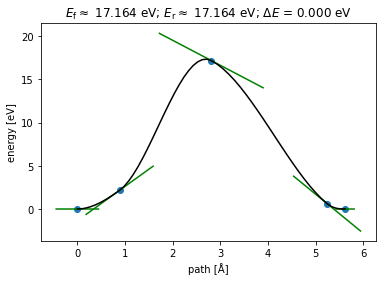

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.4370          5.6785        2.7525     +  0.1707


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2807          1.7036        0.0742     +  0.1832
      3          0.0588          1.3033        0.0272     +  0.2429
      4          0.0168          1.1544        0.0204     +  0.2047
      5          0.0388          0.7221        0.0085     +  0.1725
      6          0.0193          0.4654        0.0034     +  0.1963
      7          0.0097          0.3139        0.0015     +  0.1674
      8          0.0085          0.2517        0.0010     +  0.1687
      9          0.0081          0.2241        0.0008     +  0.1629
     10          0.0078          0.2094        0.0007     +  0.1621
     11          0.0076          0.2022        0.0006     +  0.1569
     12          0.0076          0.2001        0.0006     +  0.0215
     13          0.0076          0.2001        0.0006     +  0.1581
     14          0.0050          0.1430        0.0003     +  0.1598
     15          0.0030          0.1134        0.0002     +  0.1494
     16          0.0020          0.0981        0

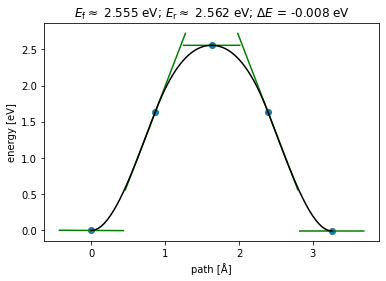

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9578          5.0472        4.3538     +  0.2216


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2504          1.4193        0.1286     +  0.2628
      3          0.0685          1.1488        0.0516     +  0.2380
      4          0.0461          0.8632        0.0287     +  0.1796
      5          0.0469          0.5645        0.0134     +  0.1883
      6          0.0332          0.4022        0.0068     +  0.2017
      7          0.0239          0.3358        0.0046     +  0.1975
      8          0.0189          0.2924        0.0034     +  0.1985
      9          0.0118          0.2285        0.0020     +  0.1868
     10          0.0095          0.2132        0.0017     +  0.2046
     11          0.0085          0.2065        0.0016     +  0.1955
     12          0.0082          0.2045        0.0016     +  0.0318
     13          0.0082          0.2045        0.0016        0.1868
     14          0.0045          0.1680        0.0010     +  0.1835
     15          0.0061          0.1465        0.0008     +  0.2040
     16          0.0067          0.1246        0

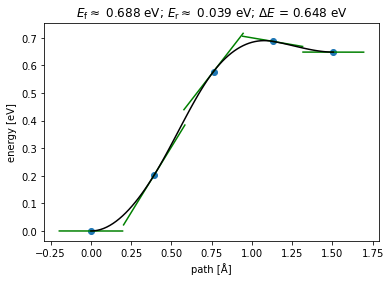

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0919          5.3170        7.9326     +  0.2679


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3599          1.6687        0.3470     +  0.2025
      3          0.0879          1.2497        0.1011     +  0.2151
      4          0.0279          0.9789        0.0563     +  0.2219
      5          0.0442          0.6085        0.0241     +  0.2152
      6          0.0277          0.4467        0.0126     +  0.2259
      7          0.0170          0.3780        0.0086     +  0.2264
      8          0.0113          0.3128        0.0058     +  0.2209
      9          0.0088          0.2729        0.0044     +  0.2338
     10          0.0071          0.2517        0.0037     +  0.2264
     11          0.0065          0.2346        0.0032     +  0.2185
     12          0.0061          0.2260        0.0030     +  0.2212
     13          0.0061          0.2260        0.0030     +  0.2287
     14          0.0048          0.1517        0.0014     +  0.2202
     15          0.0044          0.1359        0.0011     +  0.2178
     16          0.0042          0.1213        0

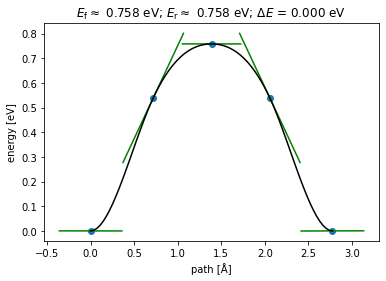

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7578          4.6127        8.5767     +  0.2157


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2077          1.2872        0.2381     +  0.2149
      3          0.0628          1.1016        0.1142     +  0.2212
      4          0.0390          0.7956        0.0584     +  0.2943
      5          0.0411          0.5474        0.0298     +  0.3593
      6          0.0242          0.3737        0.0134     +  0.3474
      7          0.0165          0.3219        0.0096     +  0.3299
      8          0.0108          0.2809        0.0071     +  0.2560
      9          0.0078          0.2521        0.0057     +  0.2599
     10          0.0066          0.2369        0.0050     +  0.2511
     11          0.0061          0.2293        0.0047     +  0.2519
     12          0.0060          0.2265        0.0045     +  0.2506
     13          0.0059          0.2265        0.0045     +  0.2433
     14          0.0053          0.1760        0.0028     +  0.2509
     15          0.0046          0.1516        0.0020     +  0.2544
     16          0.0048          0.1373        0

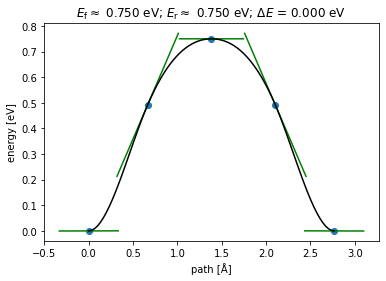

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4667          4.1561        8.7417     +  0.2541


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2331          1.3781        0.4007     +  0.2549
      3          0.0672          1.1278        0.1704     +  0.2722
      4          0.0541          0.7590        0.0799     +  0.2693
      5          0.0336          0.5155        0.0362     +  0.2692
      6          0.0234          0.4029        0.0217     +  0.2856
      7          0.0172          0.3174        0.0133     +  0.2813
      8          0.0077          0.2394        0.0072     +  0.2715
      9          0.0045          0.2129        0.0056     +  0.2819
     10          0.0036          0.1999        0.0050     +  0.2793
     11          0.0034          0.1936        0.0046     +  0.2749
     12          0.0033          0.1917        0.0046     +  0.1472
     13          0.0033          0.1917        0.0046     +  0.2817
     14          0.0040          0.1545        0.0030     +  0.2758
     15          0.0040          0.1432        0.0026     +  0.2920
     16          0.0045          0.1222        0

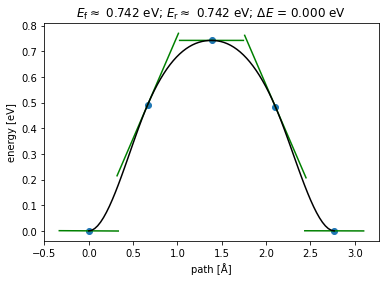

Terminating! Convergence criteria has been met


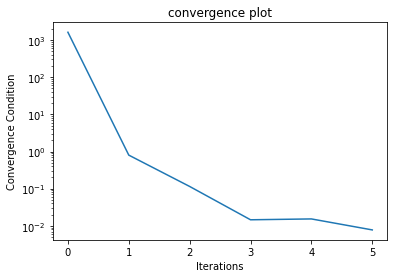

[1619.5388441409596, 0.7998634211980971, 0.11474399767757859, 0.014555597706930712, 0.015346768777817488, 0.0077689669851679355]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8996   652054.5625     +  0.0786
      2          0.0188          3.8884   648708.8750     +  0.0813


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0106          3.8634   640140.2500     +  0.0872
      4          0.0341          3.1079   415406.7188     +  0.0936
      5          0.0560          2.4686   264667.4375     +  0.1081
      6          0.0584          2.4611   263376.3750     +  0.1242
      7          0.0718          2.4558   264127.6250     +  0.1268
      8          0.0723          2.4379   260441.1094     +  0.1309
      9          0.0726          2.4302   258879.9375     +  0.1271
     10          0.0724          2.4256   257902.5156     +  0.1330
     11          0.0719          2.4219   257065.4219     +  0.1346
     12          0.0716          2.4205   256715.4062     +  0.0768
     13          0.0716          2.4205   256714.6719     +  0.1296
     14          0.0670          2.4075   253331.4844     +  0.1215
     15          0.0653          2.4001   251577.2656     +  0.1276
     16          0.0617          2.3950   250042.7969     +  0.1202
     17          0.0519          2.3637   242459

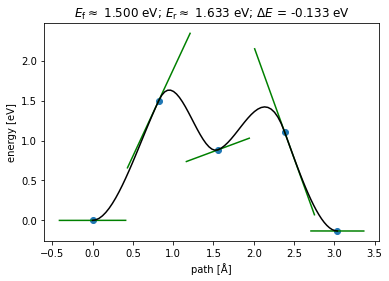

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1002          4.8581        2.4426     +  0.2139


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2876          1.5771        0.0831     +  0.2153
      3          0.0797          1.2620        0.0320     +  0.1721
      4          0.0618          1.1037        0.0240     +  0.1457
      5          0.0334          0.6639        0.0086     +  0.1646
      6          0.0083          0.5435        0.0054     +  0.1806
      7          0.0070          0.3886        0.0028     +  0.1632
      8          0.0059          0.3027        0.0017     +  0.1635
      9          0.0061          0.2593        0.0012     +  0.1680
     10          0.0063          0.2364        0.0010     +  0.1639
     11          0.0064          0.2254        0.0009     +  0.1799
     12          0.0064          0.2222        0.0009     +  0.0293
     13          0.0064          0.2222        0.0009     +  0.1624
     14          0.0057          0.1594        0.0005     +  0.1725
     15          0.0052          0.1450        0.0004     +  0.1679
     16          0.0052          0.1331        0

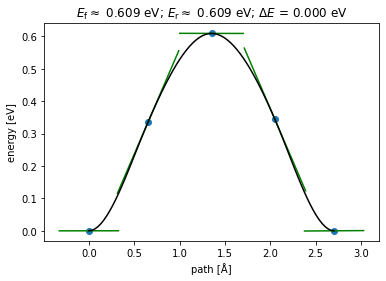

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0611          4.9309        4.9765     +  0.2425


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3631          1.8408        0.2548     +  0.2773
      3          0.0651          1.3734        0.0760     +  0.2795
      4          0.0451          1.0003        0.0401     +  0.2459
      5          0.0320          0.5492        0.0125     +  0.1837
      6          0.0170          0.3803        0.0058     +  0.1871
      7          0.0134          0.3213        0.0041     +  0.1931
      8          0.0125          0.2781        0.0031     +  0.1908
      9          0.0101          0.2321        0.0021     +  0.1939
     10          0.0081          0.2112        0.0018     +  0.1931
     11          0.0068          0.2002        0.0016     +  0.1863
     12          0.0064          0.1971        0.0015     +  0.1836
     13          0.0064          0.1970        0.0015     +  0.2077
     14          0.0022          0.1472        0.0008     +  0.1882
     15          0.0044          0.1353        0.0007     +  0.1892
     16          0.0062          0.1197        0

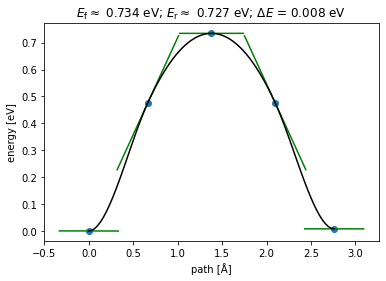

Terminating! Convergence criteria has been met


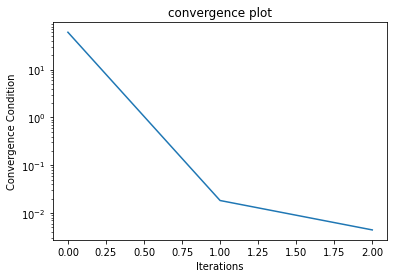

[60.72861179492611, 0.018326616162084974, 0.004445912520168349]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8992   651935.1250     +  0.0824
      2          0.0004          3.3757   488621.2500     +  0.0997


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0003          3.2806   461479.4688     +  0.0984
      4          0.0002          3.2375   449437.7188     +  0.1100
      5          0.0002          3.2128   442612.2188     +  0.1222
      6          0.0002          3.2065   440877.3125     +  0.1228
      7          0.0002          3.2045   440322.8438     +  0.1252
      8          0.0002          3.2023   439707.5625     +  0.1234
      9          0.0001          3.1979   438517.4062     +  0.1337
     10          0.0003          3.1932   437230.0625     +  0.1329
     11          0.0008          3.1857   435158.8125     +  0.1219
     12          0.0010          3.1824   434270.1875     +  0.0306
     13          0.0010          3.1824   434270.0625     +  0.1176
     14          0.0025          3.1601   428193.4688     +  0.1220
     15          0.0043          3.1315   420493.9375     +  0.1242
     16          0.0052          3.0781   406288.7500     +  0.1263
     17          0.0073          2.9561   374757

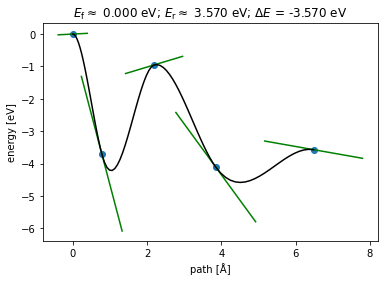

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.7203          5.8892        2.8580     +  0.1364
      2          0.2943          2.1363        0.0875     +  0.1350


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0427          1.4718        0.0288     +  0.1657
      4          0.0565          1.1556        0.0184     +  0.1479
      5          0.0368          0.7729        0.0082     +  0.1582
      6          0.0216          0.5359        0.0039     +  0.1658
      7          0.0193          0.4269        0.0025     +  0.1606
      8          0.0187          0.3693        0.0019     +  0.1619
      9          0.0178          0.3321        0.0015     +  0.1535
     10          0.0168          0.3147        0.0014     +  0.1551
     11          0.0161          0.3075        0.0013     +  0.1662
     12          0.0159          0.3056        0.0013     +  0.0196
     13          0.0159          0.3056        0.0013     +  0.1613
     14          0.0105          0.2705        0.0010     +  0.1616
     15          0.0070          0.2505        0.0008     +  0.1539
     16          0.0056          0.2307        0.0007     +  0.1659
     17          0.0047          0.2086        0

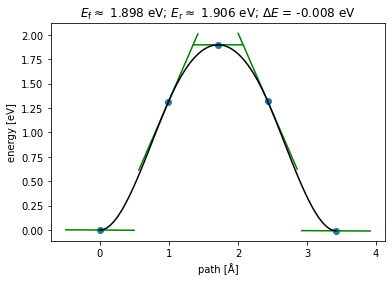

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2959          5.3658        4.9420     +  0.2319


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2334          1.8961        0.1526     +  0.2439
      3          0.0479          1.4158        0.0635     +  0.2260
      4          0.0714          1.0795        0.0398     +  0.1976
      5          0.0580          0.7024        0.0178     +  0.2053
      6          0.0256          0.5493        0.0098     +  0.2158
      7          0.0160          0.4405        0.0062     +  0.2011
      8          0.0161          0.3770        0.0046     +  0.1992
      9          0.0148          0.3371        0.0037     +  0.2184
     10          0.0134          0.3171        0.0032     +  0.2040
     11          0.0127          0.3076        0.0030     +  0.1999
     12          0.0125          0.3048        0.0030     +  0.0451
     13          0.0125          0.3048        0.0030     +  0.2180
     14          0.0074          0.2480        0.0019     +  0.1998
     15          0.0068          0.2285        0.0016     +  0.2005
     16          0.0074          0.2070        0

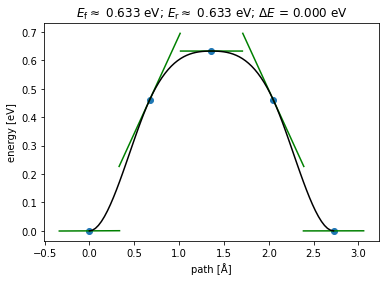

Terminating! Convergence criteria has been met


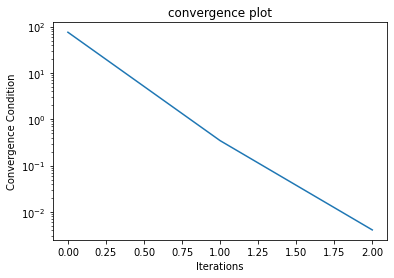

[75.5128044312587, 0.34671677157166414, 0.004107266824576072]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8924   649635.8125     +  0.0746
      2          0.0586          3.8901   652584.0625     +  0.0726
      3          0.0586          3.8889   652175.1875     +  0.0710


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      4          0.0586          3.8877   651755.9375     +  0.0743
      5          0.0586          3.8865   651351.3125     +  0.0747
      6          0.0586          3.8854   650984.4375     +  0.0808
      7          0.0586          3.8844   650673.5625     +  0.0708
      8          0.0586          3.8837   650430.8125     +  0.0735
      9          0.0586          3.8832   650260.2500     +  0.0703
     10          0.0586          3.8829   650157.1875     +  0.0719
     11          0.0586          3.8827   650109.1250     +  0.0742
     12          0.0586          3.8827   650096.7500     +  0.0101
     13          0.0586          3.8827   650096.7500        0.0757
     14          0.0586          3.8811   649581.4375     +  0.0713
     15          0.0586          3.8795   649043.5000     +  0.0745
     16          0.0587          3.8778   648485.2500     +  0.0705
     17          0.0587          3.8761   647910.1250     +  0.0748
     18          0.0587          3.8743   647322

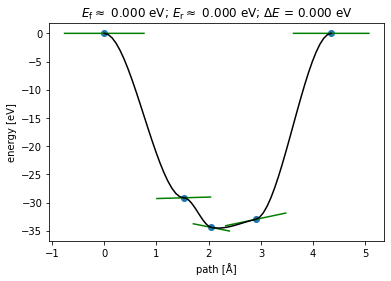

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1341          5.0830        2.3961     +  0.1818


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2404          1.6235        0.0700     +  0.2026
      3          0.0577          1.3193        0.0313     +  0.2025
      4          0.0549          1.1313        0.0232     +  0.1678
      5          0.0849          0.5986        0.0092     +  0.1799
      6          0.0370          0.5689        0.0061     +  0.1772
      7          0.0137          0.5473        0.0052     +  0.1700
      8          0.0059          0.5249        0.0047     +  0.1557
      9          0.0121          0.4989        0.0043     +  0.1637
     10          0.0175          0.4555        0.0037     +  0.1734
     11          0.0183          0.4254        0.0032     +  0.1521
     12          0.0184          0.4180        0.0031     +  0.1175
     13          0.0184          0.4180        0.0031     +  0.1680
     14          0.0162          0.3045        0.0017     +  0.1591
     15          0.0087          0.2493        0.0011     +  0.1740
     16          0.0079          0.2164        0

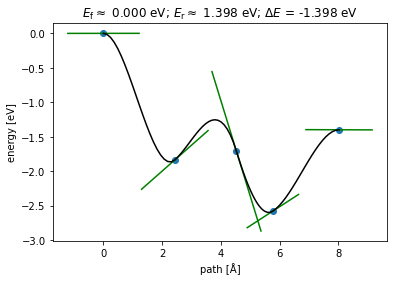

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9487          4.7980        4.3188     +  0.1594


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2375          1.3875        0.1221     +  0.1960
      3          0.0583          1.0884        0.0465     +  0.1713
      4          0.0554          0.7669        0.0243     +  0.2074
      5          0.0366          0.5138        0.0109     +  0.2062
      6          0.0168          0.3662        0.0052     +  0.1881
      7          0.0086          0.3031        0.0034     +  0.1923
      8          0.0058          0.2559        0.0024     +  0.1887
      9          0.0049          0.2331        0.0020     +  0.2020
     10          0.0045          0.2193        0.0018     +  0.1906
     11          0.0043          0.2118        0.0017     +  0.1842
     12          0.0043          0.2094        0.0016     +  0.0427
     13          0.0043          0.2094        0.0016     +  0.1937
     14          0.0038          0.1630        0.0010     +  0.1923
     15          0.0032          0.1506        0.0008     +  0.1839
     16          0.0019          0.1396        0

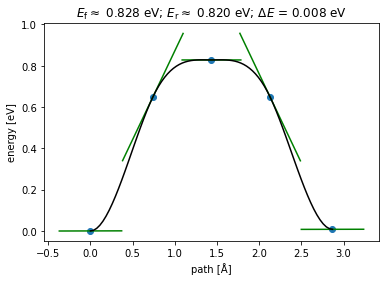

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7863          4.6926        6.4426     +  0.1854


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2638          1.5023        0.2529     +  0.1893
      3          0.0659          1.2144        0.1002     +  0.2017
      4          0.0385          0.7900        0.0418     +  0.2059
      5          0.0266          0.5114        0.0177     +  0.2149
      6          0.0188          0.3794        0.0097     +  0.2221
      7          0.0152          0.3260        0.0071     +  0.2136
      8          0.0128          0.2951        0.0058     +  0.2205
      9          0.0117          0.2728        0.0049     +  0.2246
     10          0.0111          0.2585        0.0044     +  0.2289
     11          0.0108          0.2513        0.0042     +  0.2128
     12          0.0107          0.2491        0.0041     +  0.0814
     13          0.0107          0.2491        0.0041     +  0.3590
     14          0.0079          0.2013        0.0027     +  0.3176
     15          0.0058          0.1756        0.0020     +  0.2482
     16          0.0044          0.1645        0

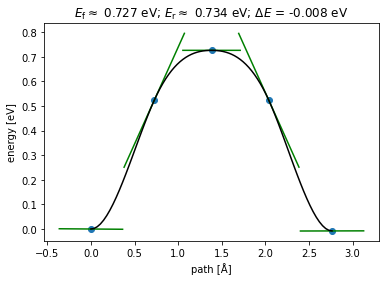

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6316          4.5510        8.4612     +  0.2075


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1908          1.3085        0.2543     +  0.2234
      3          0.0290          1.0039        0.0998     +  0.2305
      4          0.0326          0.6398        0.0423     +  0.2393
      5          0.0269          0.4511        0.0215     +  0.2468
      6          0.0207          0.3374        0.0121     +  0.2697
      7          0.0168          0.2925        0.0090     +  0.2531
      8          0.0144          0.2672        0.0074     +  0.2466
      9          0.0123          0.2512        0.0065     +  0.2567
     10          0.0110          0.2409        0.0059     +  0.2519
     11          0.0102          0.2357        0.0056     +  0.2785
     12          0.0100          0.2339        0.0055     +  0.0753
     13          0.0100          0.2339        0.0055     +  0.3830
     14          0.0049          0.1946        0.0037     +  0.2531
     15          0.0043          0.1723        0.0029     +  0.3794
     16          0.0048          0.1585        0

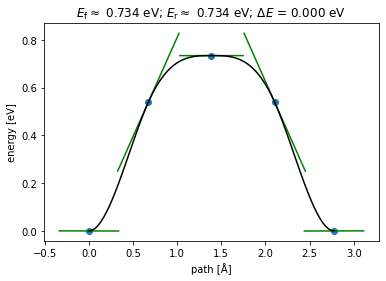

Terminating! Convergence criteria has been met


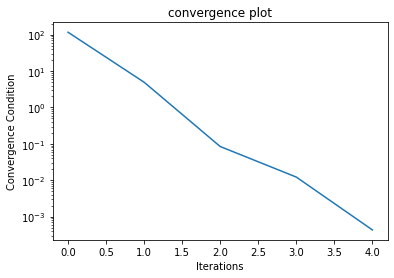

[116.2910682050715, 4.926914664625656, 0.0845669038099004, 0.012258154994924553, 0.0004337442951509729]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8985   651703.1875     +  0.0770
      2          0.0009          3.6317   565540.8750     +  0.0865


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0017          3.3203   472720.9688     +  0.0862
      4          0.0017          3.2457   451717.5625     +  0.0938
      5          0.0016          3.2262   446313.3125     +  0.1066
      6          0.0015          3.2130   442658.9375     +  0.1218
      7          0.0015          3.2087   441475.4062     +  0.1257
      8          0.0015          3.2071   441027.7188     +  0.1190
      9          0.0014          3.2061   440757.6562     +  0.1440
     10          0.0013          3.2044   440283.6875     +  0.1568
     11          0.0012          3.2029   439869.7812     +  0.1220
     12          0.0012          3.2023   439716.7188     +  0.0364
     13          0.0012          3.2023   439716.5938     +  0.2295
     14          0.0011          3.1996   438971.4688     +  0.2950
     15          0.0011          3.1816   434055.7500     +  0.2240
     16          0.0014          3.1493   425282.2500     +  0.2185
     17          0.0016          3.1369   421937

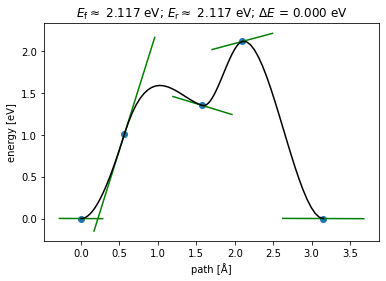

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0506          4.9172        2.3779     +  0.1911


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2042          1.7598        0.0761     +  0.1762
      3          0.0371          1.3664        0.0350     +  0.1540
      4          0.0622          1.0247        0.0211     +  0.1574
      5          0.0214          0.6239        0.0074     +  0.1561
      6          0.0045          0.4408        0.0036     +  0.1655
      7          0.0034          0.3562        0.0023     +  0.2184
      8          0.0048          0.3109        0.0018     +  0.1589
      9          0.0063          0.2796        0.0015     +  0.1610
     10          0.0071          0.2497        0.0012     +  0.1606
     11          0.0069          0.2330        0.0010     +  0.1686
     12          0.0068          0.2280        0.0010     +  0.1610
     13          0.0068          0.2280        0.0010     +  0.1627
     14          0.0037          0.1607        0.0005     +  0.1580
     15          0.0029          0.1379        0.0004     +  0.1579
     16          0.0036          0.1177        0

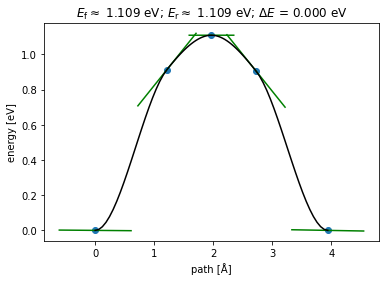

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9034          4.9934        4.7127     +  0.1387
      2          0.2769          1.4601        0.1652     +  0.1505


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0736          1.1107        0.0559     +  0.1681
      4          0.0619          0.9254        0.0389     +  0.1676
      5          0.0548          0.5768        0.0166     +  0.1963
      6          0.0256          0.4454        0.0088     +  0.1863
      7          0.0131          0.3534        0.0053     +  0.1831
      8          0.0088          0.3108        0.0040     +  0.1865
      9          0.0073          0.2769        0.0032     +  0.1839
     10          0.0069          0.2477        0.0026     +  0.1935
     11          0.0067          0.2313        0.0022     +  0.1842
     12          0.0066          0.2233        0.0021     +  0.1837
     13          0.0066          0.2233        0.0021     +  0.1877
     14          0.0073          0.1767        0.0013     +  0.1910
     15          0.0072          0.1497        0.0010     +  0.1823
     16          0.0077          0.1287        0.0007     +  0.3329
     17          0.0082          0.1128        0

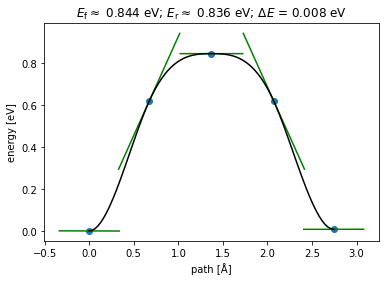

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6950          4.5018        6.2267     +  0.2882


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2051          1.3651        0.1971     +  0.2998
      3          0.0356          1.0789        0.0808     +  0.2151
      4          0.0490          0.6782        0.0352     +  0.2235
      5          0.0299          0.4456        0.0149     +  0.2640
      6          0.0177          0.3563        0.0091     +  0.2217
      7          0.0108          0.3047        0.0065     +  0.2168
      8          0.0067          0.2527        0.0044     +  0.2221
      9          0.0052          0.2102        0.0030     +  0.2146
     10          0.0046          0.1913        0.0025     +  0.2240
     11          0.0044          0.1833        0.0023     +  0.2137
     12          0.0044          0.1812        0.0023     +  0.0687
     13          0.0044          0.1812        0.0023     +  0.2108
     14          0.0049          0.1443        0.0014     +  0.2333
     15          0.0052          0.1338        0.0013     +  0.2203
     16          0.0040          0.1220        0

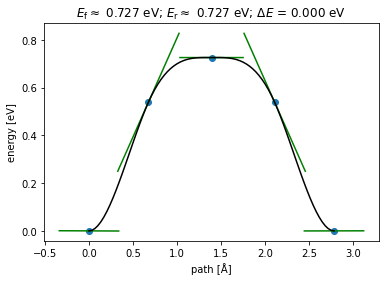

Terminating! Convergence criteria has been met


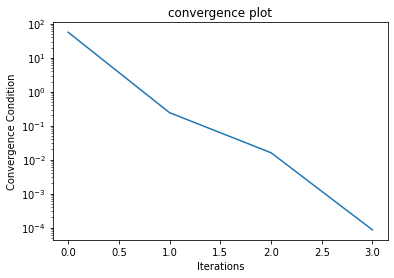

[56.27400913601741, 0.24175085696333554, 0.016038593268604018, 8.599317516200244e-05]


In [ ]:
force_calls = []
#Here we run the code 5 times to ensure consistency of the results, for testing changing the 5 to a 1 is sufficient to run a full Active learning calculation to build the NEB
for i in range(5):
    # Define symmetry functions
    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 6.0

    # Training parameters for the active learning framework
    training_params = {
            "al_convergence": {"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
            "samples_to_retrain": 1,
            "Gs": Gs,
            "morse": True,
            "forcetraining": True,
            "cores": 1,
            "optimizer": torch.optim.LBFGS,
            "batch_size": 1000,
            "criterion": CustomMSELoss,
            "num_layers": 3,
            "num_nodes": 20,
            "force_coefficient": 0.04,
            "learning_rate": 1e-2,
            "epochs": 200,
            "test_split": 0,
            "shuffle": False,
            "verbose": 1,
            "filename": "neb_nebstrat_ml2relax_True",
            "file_dir": "./",
            "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
        }

    ml2relax = True #use machine learning to relax the initial and final states rather than DFT as is the norm
    
    parent_calc = Espresso(pw=500.0, 
                    calculation='scf',
                    kpts=(4,4,1),
                    xc='PBE')
    
    initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
    images = [initial]
    images.append(final)

    # Define AL scheme

    learner = AtomisticActiveLearner(
        training_data=images,
        training_params=training_params,
        convergence_func = 'neb_convergence',
        parent_calc=parent_calc,
        ensemble=False
    )

    # Learn the corresponding atomistic method
    total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

    learner.learn(
        atomistic_method=NEBcalc(
            starting_images=images, 
            ml2relax=ml2relax, 
            intermediate_samples=total_neb_images-2), 
        query_strategy=neb_query
        )
    force_calls.append(initial_force_calls+learner.parent_calls)

In [ ]:
print('The DFT calls for each run of the active-learning framework is:',force_calls)

The DFT calls for each run of the active-learning framework is: [20, 11, 11, 17, 14]


#### Code to generate true NEB

The following code is meant to be run seperately in order to identify the NEB that is built purely using DFT

In [ ]:
dft_counter = CounterCalc(Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE'),"DFT_database1")
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(dft_counter)
  final.set_calculator(dft_counter)
  qn = BFGS(initial, trajectory='original_parent_initial.traj', logfile='original_initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = BFGS(final, trajectory='original_parent_final.traj', logfile='original_final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("original_parent_initial.traj", "-1")
  final_slab1 = read("original_parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(dft_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb1.traj')
qn.run(fmax=0.01,steps = 100)

      Step     Time          Energy         fmax
BFGS:    0 02:23:07   -66355.611084       11.9354
BFGS:    1 02:26:00   -66357.907954        2.2174
BFGS:    2 02:28:59   -66357.947721        1.0338
BFGS:    3 02:31:52   -66358.001367        0.7759
BFGS:    4 02:34:50   -66358.056930        0.7162
BFGS:    5 02:37:44   -66358.108125        0.7939
BFGS:    6 02:40:41   -66358.125509        0.5920
BFGS:    7 02:43:36   -66358.128558        0.3692
BFGS:    8 02:46:38   -66358.134617        0.3334
BFGS:    9 02:49:38   -66358.141790        0.2537
BFGS:   10 02:52:34   -66358.151593        0.2403
BFGS:   11 02:55:45   -66358.155225        0.1798
BFGS:   12 02:58:44   -66358.156063        0.1555
BFGS:   13 03:01:40   -66358.156712        0.0854
BFGS:   14 03:04:37   -66358.156825        0.0563
BFGS:   15 03:07:33   -66358.156700        0.0620
BFGS:   16 03:10:37   -66358.156634        0.0593
BFGS:   17 03:13:38   -66358.156674        0.0277
BFGS:   18 03:16:37   -66358.156715        0.0245
B

True

In [ ]:
images = read(f'actual_neb1.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE = nebtools.get_barrier(fit=False)
force = nebtools.get_fmax()

print(f"Ef = {Ef}, dE = {dE}, force = {force}")
print(f"Total number of force calls = {initial_force_calls+dft_counter.force_calls}")
fig = nebtools.plot_band()
fig.savefig('original_diffusion-barrier_dft.png')